In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
data = pd.read_csv('data/sales_train.csv')
shops_df = pd.read_csv('data/shops.csv')
items_df = pd.read_csv('data/items.csv')
categories_df = pd.read_csv('data/item_categories.csv')

In [68]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
data[data['item_cnt_day'] > 1].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
9,2013-01-03,0,25,2573,299.0,3.0
10,2013-01-03,0,25,2574,399.0,2.0
13,2013-01-08,0,25,2574,399.0,2.0
15,2013-01-11,0,25,2574,399.0,2.0
47,2013-01-10,0,25,2746,299.0,2.0


item_cnt_day - количество проданного товара, не может быть отрицательным 

In [69]:
data = data.drop(data[(data.item_cnt_day < 0) | (data.item_price < 0)].index)

In [70]:
data = data.merge(items_df.drop(['item_name'], axis=1), left_on='item_id', right_on = 'item_id', how='left')

In [26]:
print(data.shape)
data.dropna().shape

(2928492, 7)


(2928492, 7)

Нет na

In [9]:
item_1 = data[data['item_id'] == 22154]

In [10]:
item_1 = item_1.groupby(['date'], as_index=False)['item_cnt_day'].sum().sort_values(by='date').set_index('date')

In [11]:
dtr =pd.date_range('2013-01-01', '2015-10-31', freq='D')
s = pd.Series(index=dtr)
df = pd.concat([item_1,s[~s.index.isin(item_1.index)]]).sort_index()
df = df.drop([0],axis=1).fillna(0)

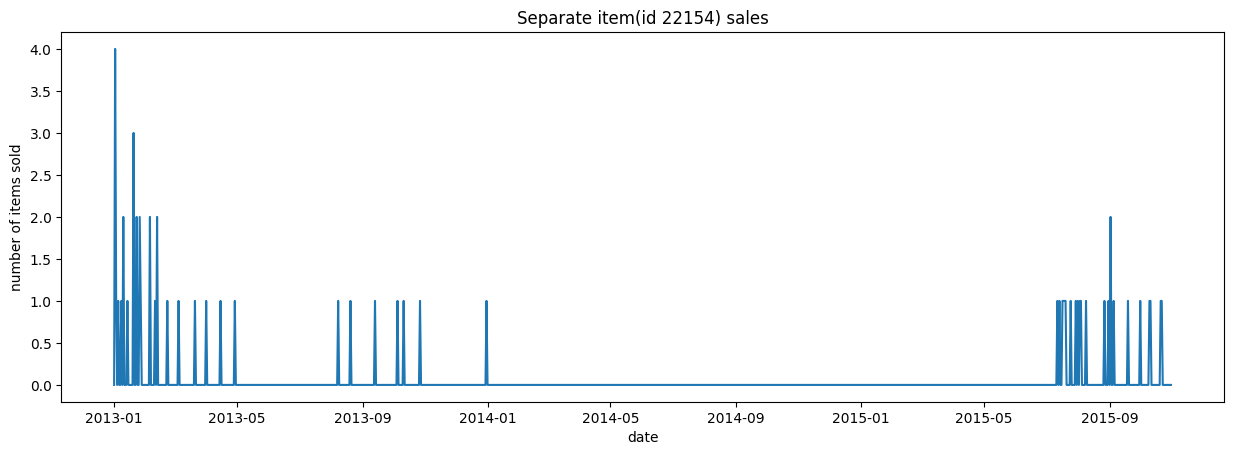

In [21]:
plt.figure().set_figwidth(15)
plt.title('Separate item (id 22154) sales')
plt.xlabel('date')
plt.ylabel('number of items sold')
plt.plot(df)

По графикам отдельных товаров сделать какие-либо выводы невозможно

In [7]:
dtr =pd.date_range('2013-01-01', '2015-10-31', freq='D')
s = pd.Series(index=dtr)

shop_num = 59
shop_concrete = data[(data['shop_id'] == shop_num)][['date', 'item_cnt_day']].groupby('date').sum()
df = pd.concat([shop_concrete, s[~s.index.isin(shop_concrete.index)]]).sort_index()
df = df.drop([0],axis=1).fillna(0)

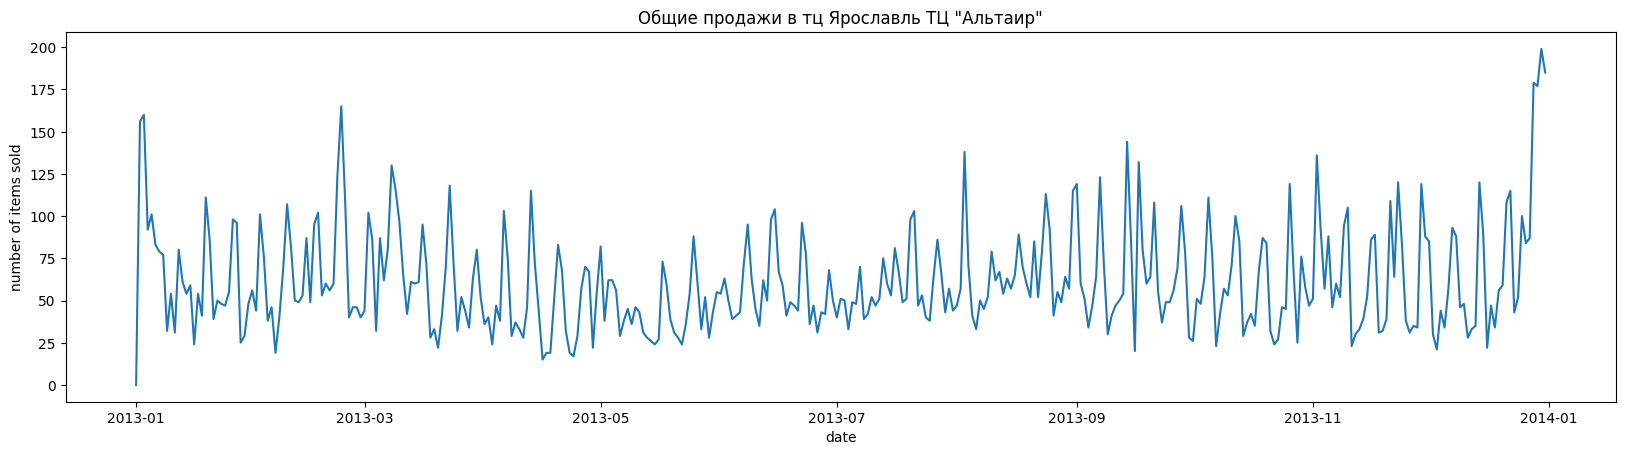

In [8]:
plt.figure().set_figwidth(20)
plt.title('Общие продажи в тц ' +  shops_df[shops_df['shop_id'] == shop_num].loc[shop_num]['shop_name'])
plt.xlabel('date')
plt.ylabel('number of items sold')
plt.plot(df[:365])

Количество пиков почти совпадает с количеством недель в данном временном промежутке => сезонность можно искать и в днях недели. Очень сильный подъем в конце года

Также заметим, что тренды продажи для магазинов очень похожи, разные только масштабы:

IndexError: index 9 is out of bounds for axis 0 with size 9

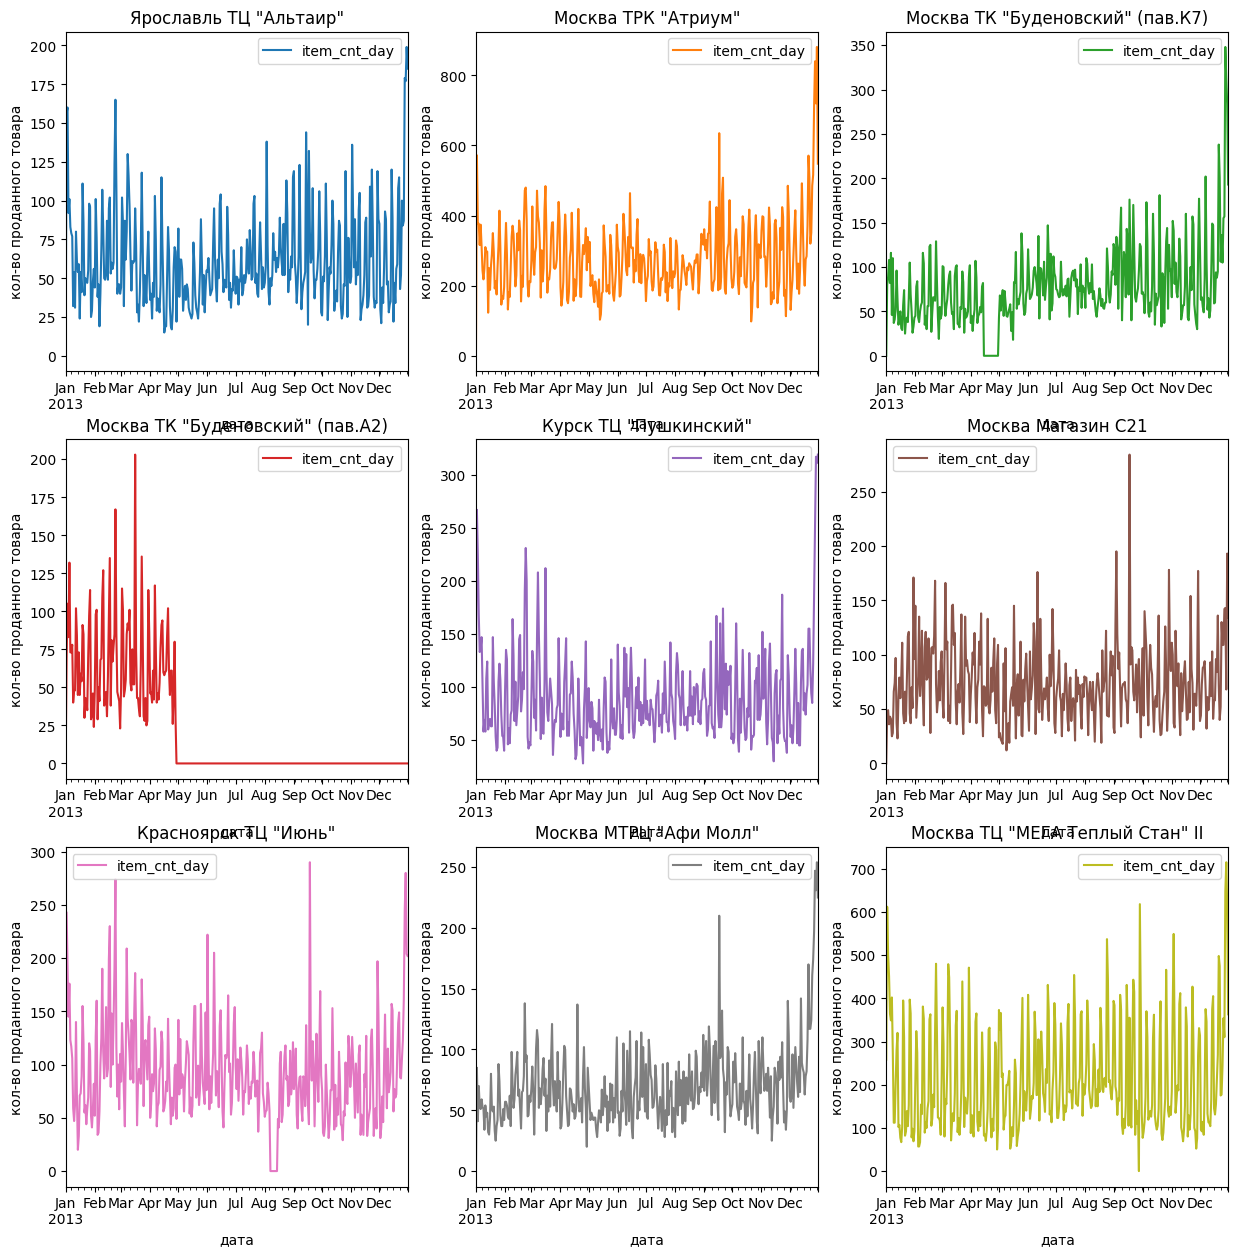

In [78]:
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.flatten()
ax_idx = 0


counter = 0
for id in data['shop_id'].unique():
    shop_concrete  = data[data['shop_id'] == id][['date', 'item_cnt_day']].groupby('date').sum()
    df = pd.concat([shop_concrete, s[~s.index.isin(shop_concrete.index)]]).sort_index()
    df = df.drop([0],axis=1).fillna(0)
    df[:365].plot(title= shops_df[shops_df['shop_id'] == id].loc[id]['shop_name'], color=next(color_cycle), ax=axs[ax_idx], ylabel='кол-во проданного товара')
    ax_idx += 1
plt.tight_layout()
plt.show()

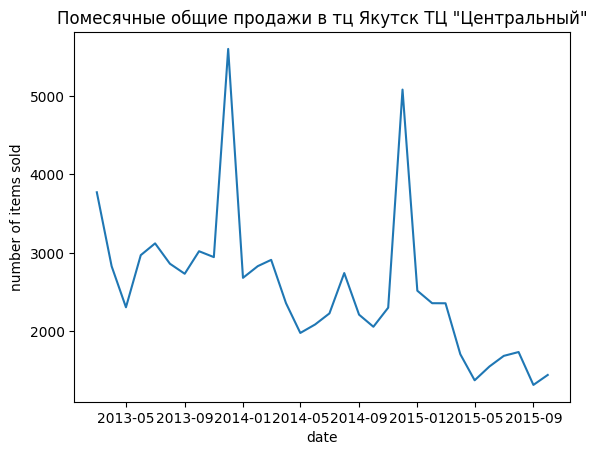

In [87]:
dtr =pd.date_range('2013-01-01', '2015-10-31', freq='M')
s = pd.Series(index=dtr)

shop_num = 58
shop_concrete = df_transform[(df_transform['shop_id'] == shop_num)][['date', 'item_cnt_day']].groupby('date').sum()
#shop_concrete.plot(title= 'Помесячные общие продажи в тц ' +  shops_df[shops_df['shop_id'] == shop_num].loc[shop_num]['shop_name'])
shop_concrete.index = shop_concrete.index.to_timestamp()
#plt.figure().set_figwidth(20)
plt.title('Помесячные общие продажи в тц ' +  shops_df[shops_df['shop_id'] == shop_num].loc[shop_num]['shop_name'])
plt.xlabel('date')
plt.ylabel('number of items sold')
plt.plot(shop_concrete)

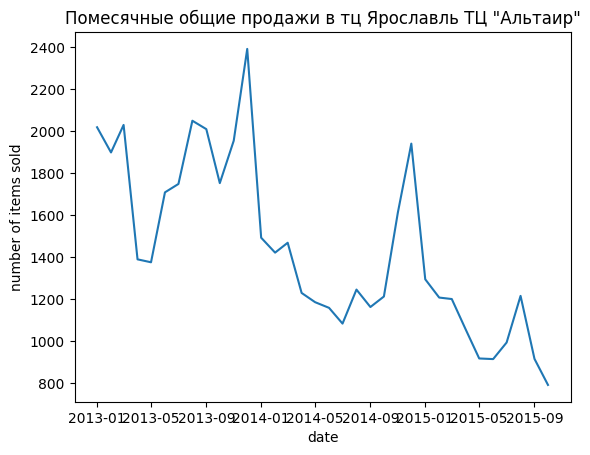

In [88]:
shop_num = 59
shop_concrete = df_transform[(df_transform['shop_id'] == shop_num)][['date', 'item_cnt_day']].groupby('date').sum()
#shop_concrete.plot(title= 'Помесячные общие продажи в тц ' +  shops_df[shops_df['shop_id'] == shop_num].loc[shop_num]['shop_name'])
shop_concrete.index = shop_concrete.index.to_timestamp()
#plt.figure().set_figwidth(20)
plt.title('Помесячные общие продажи в тц ' +  shops_df[shops_df['shop_id'] == shop_num].loc[shop_num]['shop_name'])
plt.xlabel('date')
plt.ylabel('number of items sold')
plt.plot(shop_concrete)

## Data transformations

In [61]:
df_transform = pd.read_csv('data/sales_train.csv')
shops_df = pd.read_csv('data/shops.csv')
items_df = pd.read_csv('data/items.csv')
categories_df = pd.read_csv('data/item_categories.csv')

df_transform['date'] = pd.to_datetime(df_transform['date'], format='%d.%m.%Y')
df_transform[df_transform['item_cnt_day'] > 1].head()

data = data.drop(data[(data.item_cnt_day < 0) | (data.item_price < 0)].index)

# Лаг по месяцам

In [62]:
df_transform = df_transform.groupby(['item_id', 'shop_id', pd.Grouper(freq="M", key='date')], as_index = False).agg({'item_cnt_day':'sum', 'item_price': 'mean'})
df_transform['date'] = df_transform['date'].dt.to_period('M')

In [63]:
df_transform

,item_id,shop_id,date,item_cnt_day,item_price
0,0,54,2014-09,1.0,58.0
1,1,55,2014-04,2.0,4490.0
2,1,55,2014-07,1.0,4490.0
3,1,55,2014-08,1.0,4490.0
4,1,55,2014-09,1.0,4490.0
...,...,...,...,...,...
1609119,22168,12,2013-09,1.0,799.0
1609120,22168,16,2013-02,1.0,799.0
1609121,22168,42,2013-02,1.0,799.0
1609122,22168,43,2013-03,1.0,798.5


In [ ]:
dtr =pd.date_range('2013-01-01', '2015-10-31', freq='D')
s = pd.Series(index=dtr)
df = pd.concat([item_1,s[~s.index.isin(item_1.index)]]).sort_index()
df = df.drop([0],axis=1).fillna(0)

In [26]:
categories_df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


Некоторые категории очень похожи друг на друга, возможно объединить их в одну, чтобы упростить обучение, не слишком ударив по качеству предсказаний

In [64]:
from sklearn import preprocessing


l_cat = list(categories_df.item_category_name)
for ind in range(0,1):
    l_cat[ind] = 'PC Headsets / Headphones'
for ind in range(1,8):
    l_cat[ind] = 'Access'
l_cat[8] = 'Tickets (figure)'
l_cat[9] = 'Delivery of goods'
for ind in range(10,18):
    l_cat[ind] = 'Consoles'
for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'
l_cat[25] = 'Accessories for games'
for ind in range(26,28):
    l_cat[ind] = 'phone games'
for ind in range(28,32):
    l_cat[ind] = 'CD games'
for ind in range(32,37):
    l_cat[ind] = 'Card'
for ind in range(37,43):
    l_cat[ind] = 'Movie'
for ind in range(43,55):
    l_cat[ind] = 'Books'
for ind in range(55,61):
    l_cat[ind] = 'Music'
for ind in range(61,73):
    l_cat[ind] = 'Gifts'
for ind in range(73,79):
    l_cat[ind] = 'Soft'
for ind in range(79,81):
    l_cat[ind] = 'Office'
for ind in range(81,83):
    l_cat[ind] = 'Clean'
l_cat[83] = 'Electric elements'

lb = preprocessing.LabelEncoder()
categories_df['item_category_id_fix'] = lb.fit_transform(l_cat)
categories_df['item_category_name_fix'] = l_cat
items_df = items_df.merge(categories_df[['item_category_id', 'item_category_id_fix']], on = 'item_category_id', how = 'left')
items_df.drop(['item_category_id'],axis=1, inplace=True)
items_df.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)

categories_df.drop(['item_category_id'],axis=1, inplace=True)
categories_df.drop(['item_category_name'],axis=1, inplace=True)

categories_df.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)
categories_df.rename(columns = {'item_category_name_fix':'item_category_name'}, inplace = True)
categories_df = categories_df.drop_duplicates()
categories_df.index = np.arange(0, len(categories_df))

In [65]:
categories_df

,item_category_id,item_category_name
0,14,PC Headsets / Headphones
1,0,Access
2,16,Tickets (figure)
3,8,Delivery of goods
4,6,Consoles
5,7,Consoles Games
6,1,Accessories for games
7,17,phone games
8,3,CD games
9,4,Card


In [66]:
df_transform = df_transform.merge(items_df.drop(['item_name'], axis=1), left_on='item_id', right_on = 'item_id', how='left')

In [38]:
print('Number of shops:', data['shop_id'].nunique())
categories_df.shape

Number of shops: 60


(18, 2)

60 и 18 (84) категории => можно сделать one-hot кодирование
Раз речь зашла про категории, добавлю: в условии написано, что 'the list of shops and products slightly changes every month', и возможно имеет смысл обучении перейти в рамки категории и не учитывать item_id, чтобы не зависеть от конретных продуктов

In [39]:
df_transform = df_transform.join(pd.get_dummies(data['item_category_id'], drop_first=True, prefix='category')).drop(['item_category_id'], axis=1)
df_transform = df_transform.join(pd.get_dummies(data['shop_id'], drop_first=True, prefix='shop')).drop(['shop_id'], axis=1)

Альтернативный подход: заменить дату просто на месяц/день и добавить какой-то сторонний параметр, отражающий изменение цен с годами